# Food-101 Classification

## Part 3: Classification with Mixup Augmentation and Label Smoothing

In the previous notebook, we trained an image classification model on the Food-101 dataset using traditional image augmentation to expand the limited dataset. This model achieved 89.26% Top-1 accuracy on the test set when using TTA. This notebook takes a different approach to augmentation. Rather than performing a series of image manupulations like flipping, rotating, warping, or changing contrast, we will use one single technique - Mixup Augmentation. 


### Mixup

[Mixup](https://arxiv.org/pdf/1710.09412.pdf) uses a simple but powerful technique to augment images. We create augmented images by taking two images and linearly interpolating between them. We then train the model to predict a linear interpolation of the targets. Concretely:

    new_image = t * image1 + (1-t) * image2
    new_target = t * target1 + (1-t) * target2
    
Where `t` is a value between 0 and 1 that is likely close to 0 or close to 1. The exact details of how `t` is chosen are described below. Mixup provides extremely strong regularization and is also fast to compute - you just interpolate between two images entirely on the GPU.

### Label Smoothing

Another regularization technique we will add is [label smoothing](https://arxiv.org/pdf/1701.06548.pdf). Label smoothing penalizes the model for being too confident in its predictions. This is particularly well suited for a dataset like Food-101. As we saw in the last notebook, there are many cases where the model being overconfident can go wrong. There are images where multiple food classes are present. There are mislabeled images. There are visually similar classes. These are all good reasons to avoid having a model that is overconfident. Concretely the label smoothing loss function is defined as:

$loss = (1-ε) ce(i) + ε \sum ce(j) / N$

Where $ε$ is a small value (ie 0.1) and $ce$ is the cross entropy function. Label smoothing has been found to create smoother output probability distributions over classes and train models that generalize better.

### Other Tricks

We will keep a few of the tricks used in the last notebook. We will still regularize with dropout and weight decay. We will train using progressive resizing and evaluate using TTA. This notebook basically looks at the impact of replacing traditional image augmentation with Mixup and label smoothing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from shutil import copyfile

In [3]:
bs = 96

In [4]:
path = Path('../data/food-101/')
path_img = path/'images'
path_meta = path/'meta'

In [5]:
path_train = path/'data/train'

In [6]:
x = torch.rand([32, 256, 1024], device=0, requires_grad=True)

In [8]:
(x@x.transpose(1,2)).shape

torch.Size([32, 256, 256])

In [9]:
del x
gc.collect()

40

# Creating the Dataloader

We create the dataloader using the same methods as the previous notebook. We keep the same validation split and pass the same random seed to ensure we are evaluating performance against the same validation dataset.

One key difference is here we pass `None` to the transforms, as we are not doing transformation based image augmentation.

In [10]:
data = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=None, size=256)
                                       .databunch(bs=bs, num_workers=6))

In [11]:
data

ImageDataBunch;

Train: LabelList (70448 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data\train;

Valid: LabelList (5302 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
clam_chowder,macaroni_and_cheese,tacos,macaroni_and_cheese,lobster_roll_sandwich
Path: ..\data\food-101\data\train;

Test: None

# Mixup, in Detail

Now that we have our data, we can look at what mixup does to our data. We create our mixed up image following 

    new_image = t * image1 + (1-t) * image2
    
Lets sweep through a range of `t` values to see what that looks like

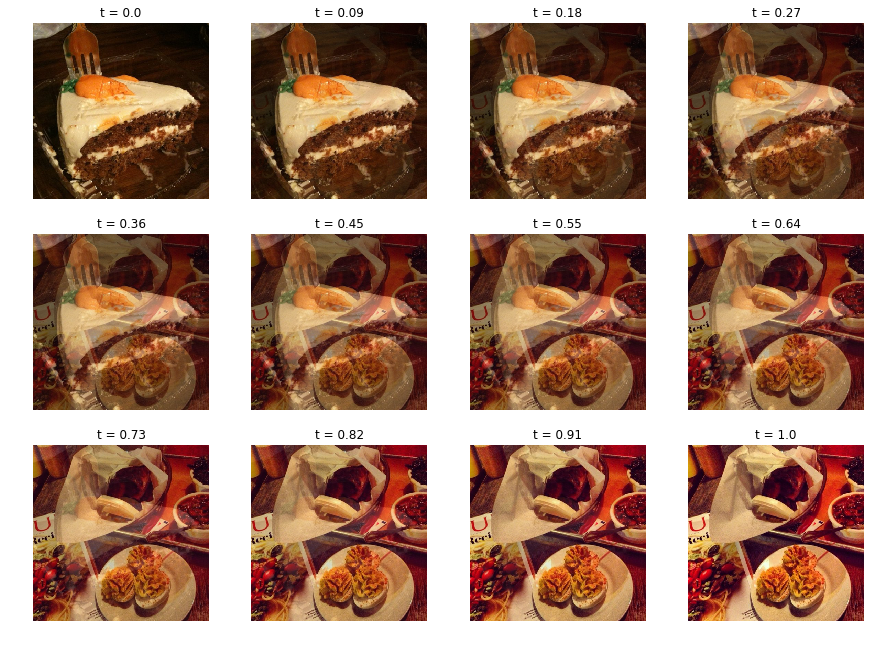

In [12]:
ts = list(np.linspace(0,1,12))

fig, axes = plt.subplots(3,4, figsize=(15,11))

for i, ax in enumerate(axes.flat):
    t = ts[i]
    mix = t*data.train_ds.x[1000].data + (1-t)*data.train_ds.x[10000].data
    show_image(mix, ax=ax)
    ax.set_title('t = ' + str(round(t,2)))

When `t` is close to 0 or close to 1, the mixed up image looks visually very similar to the original image. At `t` values close to 0.5, there's a strong visual difference. We tune the regularization of mixup by changing the probability distribution of `t` values. So how exactly do we do this?

## Selecting t

Following the Mixup paper, `t` is drawn from a beta distribution with an $\alpha$ value between 0.1 and 0.4. Using a beta distribution ensures that most of the time, `t` will be close fo 0 or close to 1, leading to moderate mixup. Increasing the $\alpha$ parameter increases the probability that `t` will be closer to 0.5.

Plotting the beta distribution for different alpha values:

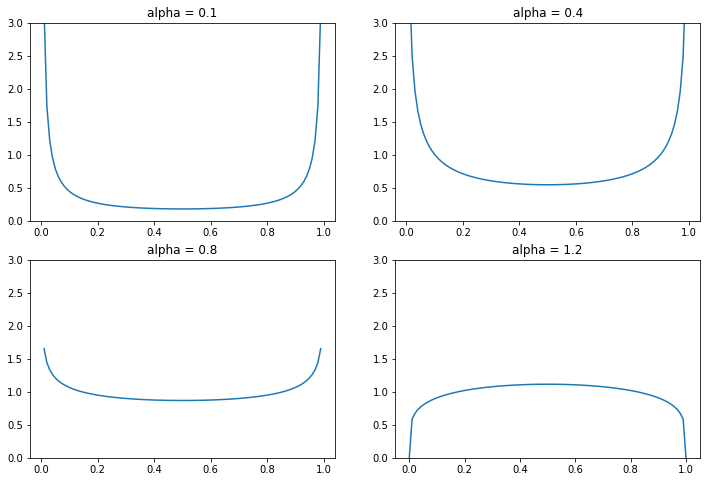

In [13]:
alphas = [0.1, 0.4, 0.8, 1.2]
x = torch.linspace(0,1,100)

fig, axes = plt.subplots(2,2, figsize=(12,8))

for i, ax in enumerate(axes.flat):
    alpha = tensor(alphas[i])
    B = alpha.lgamma().exp() * alpha.lgamma().exp() / (2*alpha).lgamma().exp()
    y = x**(alpha - 1) * (1-x)**(alpha - 1) / B
    ax.plot(x.numpy(), y.numpy())
    ax.set_title("alpha = " + str(alphas[i]))
    ax.set_ylim([0,3])

For training, we will use an $\alpha$ value of 0.4. For each batch of training data, we will draw a `t` value for each item in the batch from the beta distribution defined by $\alpha$. This gives each item in the batch a different degree of mixup.

We will use the fast.ai library to implement mixup. One detail to note is that fast.ai implements mixup on a per-batch basis. This means that mixup occurs between elements within a batch rather than over the entire dataset.

## Loss Function for Mixup

We need a loss function that implements mixup during the loss calculation following the same `t` parameters used to mixup the inputs. For example if we mixed up two images with ground truth values `[1,0,0,0]` and `[0,0,1,0]` with a value of `t=0.7`, we would want to perform our cross entropy calculation against a ground truth value of `[0.7,0,0.3,0]`. Unfortunately cross entropy in Pytorch is designed to take integer values for the ground truth. The workaround is to calculate cross entropy twice - once for each element in the mixup - and interpolate the values. Following the above example, we would have:

    loss = 0.7*ce(prediction, 0) + 0.3*ce(prediction, 2)

# Label Smoothing Cross Entropy

Our base loss function (`ce` in the above equation) will be cross entropy with label smoothing. Label smoothing cross entropy will be implemented with the fast.ai library. As described above, we want to calculate our loss following

$loss = (1-ε) ce(i) + \frac{ε}{N} \sum ce(j)$

Getting specific with the indexing, we need to exclude the true class from the summation:

$loss = (1-ε) (-log(p_{i})) + \frac{ε}{N} \sum_{j \neq i} (-log(p_{j}))$

This can get complicated, trying to find a vectorized implementation that excludes the target class for all items in a batch. fasti.ai makes a slight change to make our lives easier. We can instead calculate:

$loss = (1 - \frac{N-1}{N} ε) (-log(p_{i})) + \frac{ε}{N} \sum_{j \neq i} (-log(p_{j}))$

This simplifies to 

$loss = (1-ε) (-log(p_{i})) + \frac{ε}{N} \sum (-log(p_{j}))$

This allows us to compute the loss by simply summing the log probabilities for all classes. The caveat is that now our ε is actually $\frac{N}{N-1} ε$, but for our dataset which has 101 classes, this scaling factor evaluates to 1.01, so the distorsion is minimal. 

# Model Training

Now it's time to train the model. We will use the same setup as the last notebook, the only difference here being that we are replacing tranditional image augmentation with label smoothing and mixup.

Our base model will be a pre-trained Resnet-50 model. We will use a weight decay value of 0.01 and the same dropout parameters that we used in the last notebook.

The training process will follow the same format. First we will train only the new linear head on 256x256 images. Then we will unfreeze and train the entire model on 256x256 images. We will then increase the image size to 512x512 and continue training.

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, loss_func=LabelSmoothingCrossEntropy())
learn = learn.mixup()

In [15]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True),
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

In [16]:
learn = learn.to_fp16(dynamic=True);
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


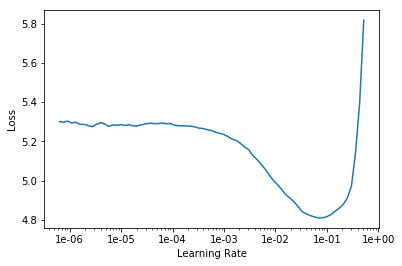

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
# Train the linear head
learn.fit_one_cycle(5, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,3.037704,2.195600,0.412109,06:06
1,2.864329,2.004747,0.347793,05:54
2,2.697639,1.869123,0.302527,05:54
3,2.585241,1.751005,0.267069,05:53
4,2.499472,1.727656,0.260279,05:54


In [19]:
learn.save('food_mix-1')

In [20]:
learn.unfreeze()

In [21]:
# Train entire model
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.480370,1.695899,0.254055,06:38
1,2.448390,1.683078,0.254809,06:34
2,2.382849,1.656449,0.250094,06:36
3,2.297576,1.588725,0.230102,06:34
4,2.185250,1.532141,0.214447,06:35
5,2.058528,1.499698,0.208223,06:34
6,1.966090,1.468864,0.191814,06:34
7,1.912249,1.463054,0.196341,06:35
8,1.867429,1.455946,0.190871,06:36
9,1.857995,1.456224,0.191060,06:34


In [22]:
learn.save('food_mix-2')

In [10]:
learn.load('food_mix-2');

As in the last notebook, we can check in on the mistakes the model is making. In the last notebook I plotted top losses, but this did not turn out to be very useful given that the top losses are usually due to mislabeling.

In [23]:
interp = ClassificationInterpretation.from_learner(learn.to_fp32())
losses,idxs = interp.top_losses()

This is interesting to compare to the previous notebook. When training with image augmentation, at this stage there were 25 class combinations that had more than 4 confused predictions. Now with mixup and label smoothing, there are only 15 class combinations. At this stage both models had about 19% error rate on the validation set. So it seems mixup and label smoothing is doing something good.

At the same time, we see a lot of the same class mixups. Dumplings vs gyoza, chocolate cake vs chocolate mousse, prime rib vs steam, beef tartare vs tuna tartare.

In [24]:
interp.most_confused(min_val=4)

[('dumplings', 'gyoza', 11),
 ('chocolate_cake', 'chocolate_mousse', 9),
 ('prime_rib', 'steak', 9),
 ('ice_cream', 'frozen_yogurt', 8),
 ('steak', 'filet_mignon', 7),
 ('beef_tartare', 'tuna_tartare', 6),
 ('filet_mignon', 'steak', 6),
 ('spaghetti_carbonara', 'spaghetti_bolognese', 5),
 ('tuna_tartare', 'beef_tartare', 5),
 ('chocolate_mousse', 'chocolate_cake', 4),
 ('grilled_salmon', 'pork_chop', 4),
 ('huevos_rancheros', 'croque_madame', 4),
 ('huevos_rancheros', 'nachos', 4),
 ('pork_chop', 'steak', 4),
 ('red_velvet_cake', 'chocolate_cake', 4)]

# Training on 512x512

Now we move to training on 512x512 images. We will follow a similar strategy. First we will train only the linear head. Then we will unfreeze and train the entire model.

In [30]:
data_hr = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=None, size=512)
                                       .databunch(bs=22, num_workers=6))

In [26]:
data_hr

ImageDataBunch;

Train: LabelList (70448 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data\train;

Valid: LabelList (5302 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
clam_chowder,macaroni_and_cheese,tacos,macaroni_and_cheese,lobster_roll_sandwich
Path: ..\data\food-101\data\train;

Test: None

In [27]:
learn.data = data_hr
learn = learn.to_fp16(dynamic=True)
learn.freeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


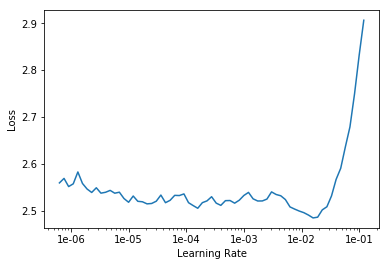

In [31]:
learn.recorder.plot(skip_end=10)

In [32]:
learn.fit_one_cycle(3, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.318624,1.465219,0.195964,18:13
1,2.208633,1.425651,0.180687,18:29
2,2.150371,1.422335,0.183327,18:18


In [33]:
learn.save('food_mix-3')

In [13]:
learn.load('food_mix-3');

In [34]:
learn.unfreeze()

In [35]:
learn.fit_one_cycle(10, max_lr=slice(5e-6,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.162849,1.410865,0.175028,26:16
1,2.225854,1.449507,0.187665,26:06
2,2.224741,1.486889,0.202754,26:04
3,2.178622,1.423921,0.181064,26:05
4,2.083577,1.396808,0.176349,26:07
5,1.986784,1.374846,0.170313,26:04
6,1.940761,1.359724,0.163523,26:05
7,1.847891,1.349446,0.164089,26:02
8,1.838726,1.344389,0.156167,26:07
9,1.819129,1.343495,0.157865,25:59


In [36]:
learn.save('food_mix-4')

In [11]:
learn.load('food_mix-4')
learn.unfreeze()

In [37]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.774352,1.340179,0.156167,25:56
1,1.805580,1.355969,0.161071,25:59
2,1.797861,1.351143,0.155602,26:03
3,1.818538,1.351399,0.156922,26:03
4,1.796418,1.356134,0.159751,26:00
5,1.758559,1.357058,0.157299,25:58
6,1.746199,1.359389,0.158431,26:02
7,1.784565,1.365317,0.158619,26:06
8,1.780895,1.361504,0.156733,26:03
9,1.774694,1.363566,0.155979,26:04


In [38]:
learn.save('food_mix-5')

At this point I stopped training.


# Prediction

We will predict on the test set twice - once without TTA and once with TTA.

## Prediction Without TTA

Here we make a prediction dataloader that contains the test set. While we did not use image transformation functions during training, I will pass them to the dataloader here. The reason for this is we will need the transform functions when we predict with TTA. Mixup is a great augmentation and regularization method, but it can't be used for TTA.

In [39]:
tfms = get_transforms(
                        do_flip=True,
                        flip_vert=True,
                        max_rotate=10.0,
                        max_zoom = 1.1,
                        max_lighting=0.25,
                        max_warp=0.25,
                        )

In [40]:
data_test = (ImageList.from_folder(path/'data').split_by_folder(train='train', valid='test')
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=64, num_workers=6))

In [41]:
learn.data = data_test

In [42]:
learn.data

ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: ..\data\food-101\data;

Test: None

In [43]:
learn = learn.to_fp32()

In [44]:
preds, y = learn.get_preds()

In [45]:
accuracy(preds, y)

tensor(0.8832)

Prediction without TTA gets us to 88.32% accuracy.

## Prediction with TTA

Now we predict using TTA using the same parameters described in the previous notebook.

In [46]:
preds_tta, y_tta = learn.TTA(beta=0.4, scale=1.05)

In [47]:
accuracy(preds_tta, y_tta)

tensor(0.8875)

Using TTA we increase our accuracy from 88.32% to 88.75%.

# Interpreting Predictions

Lets look at some of the failure cases on the test set. In the last notebook, I found that most of the top losses corresponded to mislabeled examples. Here I'll just go straight to the confused classes comparison.

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

Here we see many of the same class confusions that we saw in the last model. Mixup and label smoothing was unable to make the model robust to similar classes.

In [50]:
interp.most_confused(min_val=9)

[('filet_mignon', 'steak', 48),
 ('steak', 'filet_mignon', 31),
 ('chocolate_mousse', 'chocolate_cake', 28),
 ('pork_chop', 'steak', 22),
 ('steak', 'prime_rib', 21),
 ('chocolate_cake', 'chocolate_mousse', 20),
 ('prime_rib', 'steak', 19),
 ('tuna_tartare', 'beef_tartare', 17),
 ('ice_cream', 'frozen_yogurt', 15),
 ('bread_pudding', 'apple_pie', 14),
 ('apple_pie', 'bread_pudding', 13),
 ('beef_tartare', 'tuna_tartare', 13),
 ('dumplings', 'gyoza', 13),
 ('bread_pudding', 'french_toast', 12),
 ('chicken_quesadilla', 'breakfast_burrito', 12),
 ('chocolate_mousse', 'panna_cotta', 12),
 ('pork_chop', 'grilled_salmon', 12),
 ('ramen', 'pho', 12),
 ('clam_chowder', 'lobster_bisque', 11),
 ('club_sandwich', 'grilled_cheese_sandwich', 11),
 ('donuts', 'beignets', 11),
 ('ravioli', 'gnocchi', 11),
 ('tiramisu', 'chocolate_mousse', 11),
 ('cheesecake', 'carrot_cake', 10),
 ('filet_mignon', 'pork_chop', 10),
 ('foie_gras', 'beet_salad', 10),
 ('nachos', 'tacos', 10),
 ('onion_rings', 'fried_cal

# Comparison to Previous Model

Compared to the model trained with traditional image augmentation, the mixup/label smoothing model performs slightly worse.

The traditional augmentation model achieved 88.53% accuracy without TTA and 89.26% accuracy with TTA. The current model achieved 88.32% accuracy without TTA and 88.75% accuracy with TTA.

It's interesting to note that the model trained with traditional image augmentations received a greater accuracy boost from TTA. The traditional model's accuracy increased by 0.73% due to TTA, while the mixup model's accuracy increased by 0.43%. I expect this is due to training on augmented images. The model trained using image augmemntations is better at predicting on augmented images.

Looking at the top 10 class confusions for each model, they look more or less the same. The mixup model is much worse at telling steak from filet mignon, but the other class confusions are of more of less the same degree. I suppose this makes sense given that the performance difference between the two models is 0.21% (without TTA).

With Mixup/Label Smoothing: 

    ('filet_mignon', 'steak', 48),
    ('steak', 'filet_mignon', 31),
    ('chocolate_mousse', 'chocolate_cake', 28),
    ('pork_chop', 'steak', 22),
    ('steak', 'prime_rib', 21),
    ('chocolate_cake', 'chocolate_mousse', 20),
    ('prime_rib', 'steak', 19),
    ('tuna_tartare', 'beef_tartare', 17),
    ('ice_cream', 'frozen_yogurt', 15),
    ('bread_pudding', 'apple_pie', 14)
    
With Image Augmentation:
    
    ('steak', 'filet_mignon', 39),
    ('filet_mignon', 'steak', 33),
    ('chocolate_mousse', 'chocolate_cake', 28),
    ('tuna_tartare', 'beef_tartare', 22),
    ('chocolate_cake', 'chocolate_mousse', 21),
    ('pork_chop', 'steak', 19),
    ('steak', 'prime_rib', 19),
    ('bread_pudding', 'apple_pie', 17),
    ('dumplings', 'gyoza', 17),
    ('apple_pie', 'bread_pudding', 16)

# TSNE Projections

Here we run the same TSNE clustering as in the last notebook. Comparing the clusters is very interesting. When all 101 classes are clustered, we see a very different clustering pattern here compared to the image augmentation model. The image uagmentation model had well defined clusters for each class, which a small region in the center of the plot that showed mixing of clusters.

The mixup/label smoothing model is dominated in the center by a big blob of classes all mixed together. I believe this is due to the effect of label smoothing. Clustering is run on the softmax of the model output. Without label smoothing, most class vectors have a prediction of close to 1 for the correct class and close to 0 for every other class. This leads to sharper clusters in the TSNE projection. With label smoothing, the model is pushed towards having less probability mass on the correct class and more probability mass on other classes. This leads to the undefined clustering seen below.

In [51]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

In [52]:
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_tta)

In [53]:
prob_df = pd.DataFrame(np.concatenate((probs_trans, y[:,None]), axis=1), columns=['x','y','labels'])

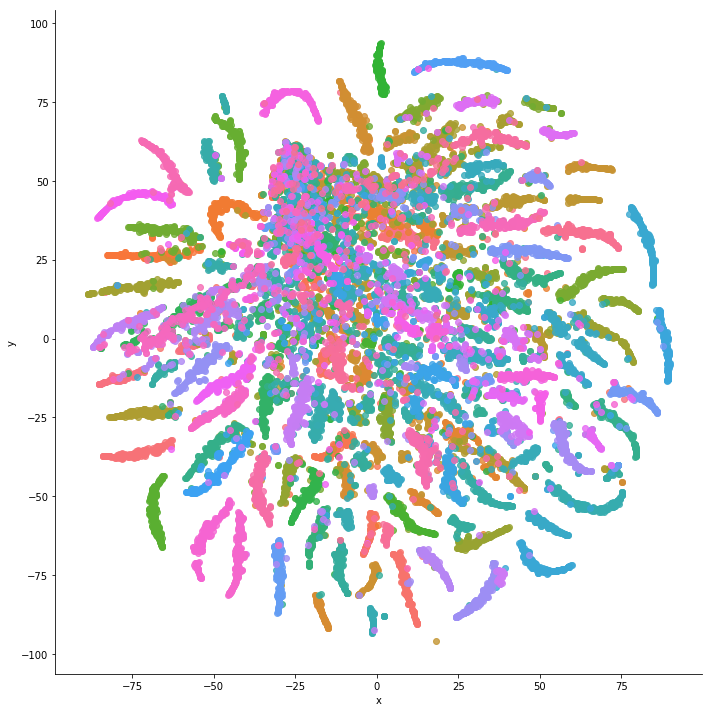

In [54]:
g = sns.lmplot('x', 'y', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10)

Here we cluster the same categories as in the previous notebook.

In [65]:
cats = ['steak', 'filet_mignon', 'tuna_tartare', 'beef_tartare', 'prime_rib', 'pork_chop']

codes = [data_test.classes.index(i) for i in cats]

bad_preds = [preds_tta[y==i] for i in codes]
bad_ys = [y_tta[y==i] for i in codes]

preds_stack = torch.cat(bad_preds, dim=0)
ys_stack = torch.cat(bad_ys, dim=0)

In [66]:
bad_tsne = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_stack)

In [67]:
bad_df = pd.DataFrame(np.concatenate((bad_tsne, ys_stack[:,None]), axis=1), columns=['x','y','labels'])

With commonly confused classes, we see even more cluster mixing than with the image augmentation model.

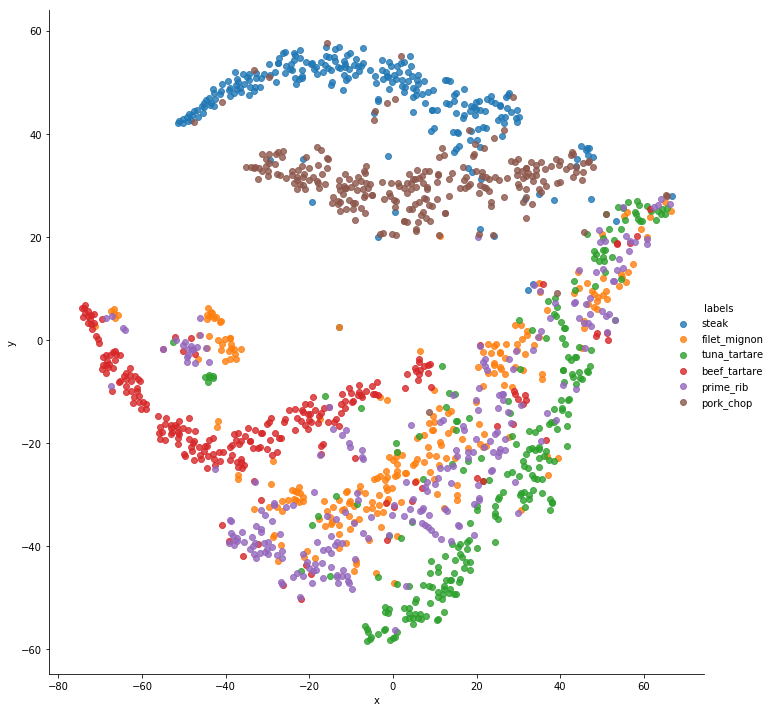

In [68]:
h = sns.lmplot('x', 'y', data=bad_df, hue='labels', fit_reg=False, legend=True, height=10)
for t, l in zip(h._legend.texts, cats): t.set_text(l)


In [59]:
cats = ['red_velvet_cake', 'risotto', 'waffles', 'apple_pie', 'garlic_bread', 'french_fries']

codes = [data_test.classes.index(i) for i in cats]

bad_preds = [preds_tta[y==i] for i in codes]
bad_ys = [y_tta[y==i] for i in codes]

preds_stack = torch.cat(bad_preds, dim=0)
ys_stack = torch.cat(bad_ys, dim=0)

In [60]:
bad_tsne = manifold.TSNE(n_components=2, perplexity=10).fit_transform(preds_stack)

In [61]:
bad_df = pd.DataFrame(np.concatenate((bad_tsne, ys_stack[:,None]), axis=1), columns=['x','y','labels'])

With well classified classes, we still see pretty good clustering

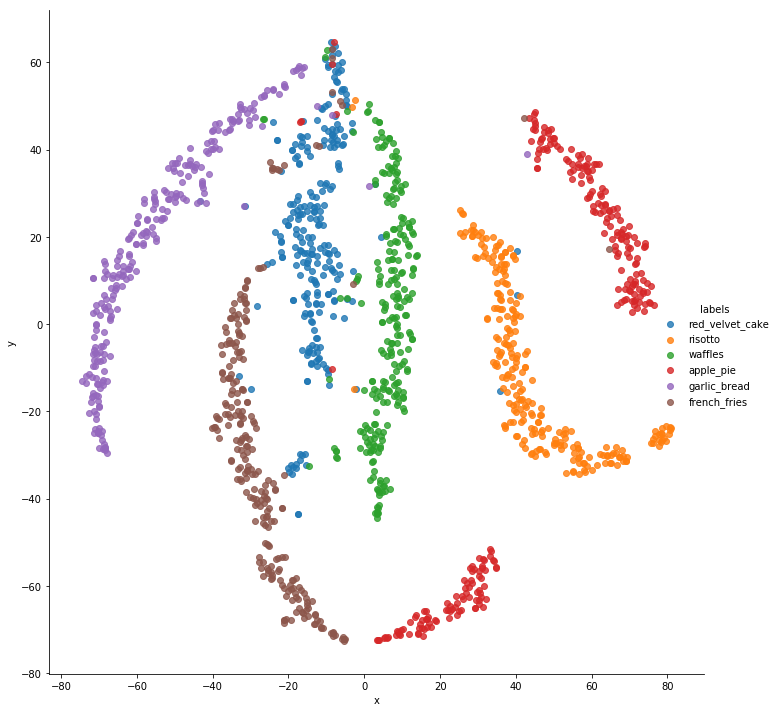

In [62]:
h = sns.lmplot('x', 'y', data=bad_df, hue='labels', fit_reg=False, legend=True, height=10)
for t, l in zip(h._legend.texts, cats): t.set_text(l)
